In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from tqdm.autonotebook import tqdm
import seaborn as sns
from Environments.NonStationaryBandits import NonStationaryEnv
from BasalGanglia.train import train
import pickle
from utils.utils import load_yaml
import os

C:\Users\chari\AppData\Local\Temp\ipykernel_16640\3874771405.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load HyperParams

In [3]:
params = load_yaml(os.path.join(os.getcwd(), r'hyperparams\NonStationaryBandits_hyperparams.yaml'))

In [ ]:
TRAILS = params['TRAILS']
EPOCHS = params['EPOCHS']
BINS = params['NUM_BINS']
LR = params['LR'] #0.005 #0.0025
NUM_ARMS = params['NUM_ARMS']
SCALING_FACTOR = params['SCALING_FACTOR']   
TIME_STAMP_CHANGE = params['TIME_STAMP_CHANGE']
BIN_SIZE = TRAILS//BINS
BIN_CHANGE = TIME_STAMP_CHANGE // BIN_SIZE

## TRAINING LOOP

In [43]:
env = NonStationaryEnv(
    num_arms = NUM_ARMS, 
    mean_reward = np.array([20,40,30])/SCALING_FACTOR, 
    std = np.array([5,5,5])/SCALING_FACTOR, 
    mean_rew_change = np.array([10,35,40])/SCALING_FACTOR, 
    std_change = np.array([5,5,5])/SCALING_FACTOR, 
    time_stamp_change = TIME_STAMP_CHANGE)

BEST_ARM_BEFORE = 1
BEST_ARM_AFTER = 2

BEST_ARM = torch.zeros((EPOCHS,TRAILS), dtype=int)
BEST_ARM[:,:TIME_STAMP_CHANGE] = BEST_ARM_BEFORE
BEST_ARM[:,TIME_STAMP_CHANGE:] = BEST_ARM_AFTER  

In [60]:
reward_monitor, arm_chosen_monitor, avg_counts,ip_monitor, dp_monitor,ep_monitor= train(env, 
                                                      trails = TRAILS, 
                                                      epochs = EPOCHS, 
                                                      lr = LR, 
                                                      bins = BINS,
                                                      STN_data = None, #'rossler',
                                                      d1_amp=0.7,
                                                      d2_amp=0.01, 
                                                      gpi_threshold=0.3,
                                                      max_gpi_iters=50,
                                                      del_lim=1, train_IP = False, 
                                                      del_med = None, printing = False,
                                                      gpi_mean= 1, ep_0 = 0.1,
                                                      alpha_ep = 0.1,
                                                      eta_ep = 0.1,
                                                      baseline_ep = 0.0, ep_lim = 0.1)

Using Random noise


## ANALYSIS

In [61]:
mean_picks = {key: torch.mean(avg_counts[key], dim = 0) for key in list(avg_counts.keys())}
IP_avg = {key: torch.mean(ip_monitor[key], dim =0).detach().numpy() for key in list(ip_monitor.keys())}
DP_avg = {key: torch.mean(dp_monitor[key], dim =0).detach().numpy() for key in list(dp_monitor.keys())}
IP_var = np.std(np.stack(list(IP_avg.values()), axis=0),axis = 0)[:,0]
arm_chosen_monitor = arm_chosen_monitor.to(torch.int)
# Computing Accuracy
accuracy_percentages = torch.zeros((EPOCHS, BINS))

for i in range(BINS):
    start, end = i * BIN_SIZE, (i + 1) * BIN_SIZE
    correct_choices = torch.sum(arm_chosen_monitor[:, start:end] == BEST_ARM[:,start:end], axis = 1)
    accuracy_percentages[:, i] = (correct_choices / BIN_SIZE) * 100

accuracy_per_bin = torch.mean(accuracy_percentages,axis = 0)

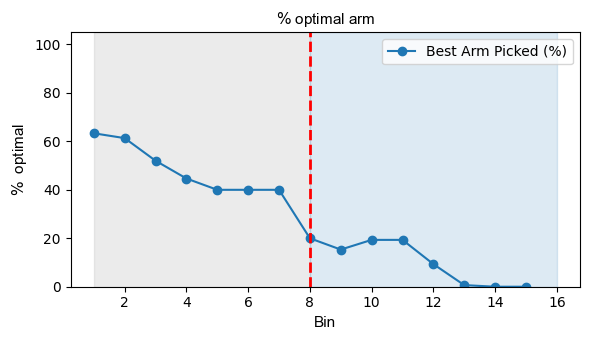

In [59]:
# Plot: Probability/Percentage of Picking the Best Arm Across Bins
BIN = np.arange(BINS)+1
font = {'family': 'Arial', 'size': 11}
plt.figure(figsize=(6,3.5))
plt.plot(BIN, accuracy_per_bin, marker='o', label='Best Arm Picked (%)')
plt.axvline(BIN_CHANGE+1, color='red', linestyle='--', linewidth=2)
plt.xlabel('Bin', **font)
plt.ylabel('$\%$  optimal', **font)
plt.title('$\%$ optimal arm', **font)
# Shade both sides of the reward change
plt.axvspan(1, BIN_CHANGE+1, color='tab:gray', alpha=0.15)
plt.axvspan(BIN_CHANGE+1, BIN[-1]+1, color='tab:blue', alpha=0.15)
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()
plt.show()

(0.0, 0.3)

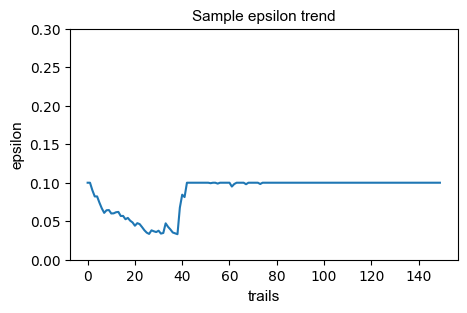

In [ ]:
sample_number = 4
BIN = np.arange(BINS)+1
font = {'family': 'Arial', 'size': 11}
plt.figure(figsize=(5,3))
plt.plot(np.arange(TRAILS), ep_monitor[sample_number])
plt.xlabel('trails', **font)
plt.ylabel('epsilon', **font)
plt.title('Sample epsilon trend', **font)
plt.ylim(0,0.3)
